# Compute the Stopping Distance for a Projectile
Compute the stopping distance of a projectile using the multi-velocity machine learning model.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.stop_distance import StoppingDistanceComputer
from stopping_power_ml.integrator import TrajectoryIntegrator
import pickle as pkl
import pandas as pd
import numpy as np
import keras
import os

Using TensorFlow backend.
/home/lward/miniconda3/envs/ml_tddft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lward/miniconda3/envs/ml_tddft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lward/miniconda3/envs/ml_tddft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lward/mi

## Load in the Model and Featurizer
The model is saved in Keras h5, and the featurizer is in the root directory

In [2]:
model = keras.models.load_model(os.path.join('..', 'model-random-and-channel.h5'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [3]:
with open(os.path.join('..', 'featurizer.pkl'), 'rb') as fp:
    featurizers = pkl.load(fp)

In [4]:
start_frame = pkl.load(open(os.path.join('..', '..', 'al_starting_frame.pkl'), 'rb'))

Get the channel data at a single velocity

In [5]:
channel_data = pd.read_pickle(os.path.join('..', '..', 'single-velocity', 'data', 'channel_data.pkl.gz')).query('average_range')

Get the minimum velocity of all training data

In [6]:
min_velocity = pd.read_pickle(os.path.join('..', '..', 'training_data.pkl.gz'))['velocity_mag'].min()

## Make the Trajectory Integration Tool
This will black box the annoying parts of computing the force given position and velocity magnitude

In [7]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizers)

In [8]:
f = traj_int.create_force_calculator_given_displacement([0, 0.75, 0.75], [1, 0, 0])

Compare the predictions to the ML model run on the channel data

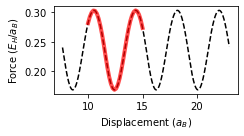

In [9]:
fig, ax = plt.subplots()

X = np.linspace(10, 15, 32)

ax.plot(channel_data['displacement'], 
        model.predict(channel_data[featurizers.feature_labels()]),
        'k--')
ax.plot(X, [f(x, channel_data['velocity_mag'].mean()) for x in X], label='Force Calculator',
       alpha=0.7, color='r', lw=4)

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_H / a_B$)')

fig.set_size_inches(3.5, 2)
fig.tight_layout()

*Finding*: The predictions of the trajectory integrator (red) do agree with running the model on the training set. So, my implementation of the force function is correct

## Make the Stopping Distance Tool
Computing the stopping distance is accomplished by using Newton's Laws of Motions to determine how far the projectile travels before its velocity drops below a threshold. We are able to compute the force on the projectile using our ML model, and can solve Newton's Laws of Motion using standard ODE solvers. Hooking the ML model into the solvers requires a minor amount of glue code, so we have created a tool to provide a simpler interface

In [10]:
stop_comp = StoppingDistanceComputer(traj_int)

In [11]:
# Make sure the pickling works
assert isinstance(pkl.loads(pkl.dumps(stop_comp)), StoppingDistanceComputer)

## Estimate Stopping Distance Along Channel
Use an ODE solver to get the stopping distance along a channel

In [12]:
%%time
dist_channel, pos_channel = stop_comp.compute_stopping_distance([0, 0.75, 0.75], [4, 0, 0], output=1)

Step: 39 - Time: 43111.37556421042 - Velocity: 0.39424409113210884 - Position: 106215.95563341459513495
CPU times: user 2.62 s, sys: 2.66 s, total: 5.28 s
Wall time: 1.74 s


In [13]:
print('Stopping distance: {:.2f} a_B'.format(dist_channel))

Stopping distance: 106154.21 a_B


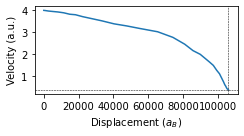

In [14]:
fig, ax = plt.subplots()

ax.plot(pos_channel['displacement'], pos_channel['velocity'])
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Velocity (a.u.)')

# Plot the stopping distance and time
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), [0.4]*2, 'k--', lw=0.5)
ax.plot([dist_channel]*2, ax.get_ylim(), 'k--', lw=0.5)


fig.set_size_inches(3.5, 2)
fig.tight_layout()

*Finding*: The curve has a reasonable shape. More or less linear at the beginning, and then quickly dropping as the particle slows down and the stopping power increases. The long flat tail is an artifact of the stopping power going to zero at non-zero velocity. The black dashed line shows the minimum velocity present in the training set. You'll note that the artifact is outside of our training range, suggesting we would need more training data at this velocity than what we currently have

## Check that the tool works for off-channel trajectories
These will have sharper changes in force than the on-channel directories. In this version, we also do not attempt to determine a stopping distance

In [15]:
off_channel = [4, 2, 1]
off_channel = np.divide(off_channel, np.linalg.norm(off_channel)) * 4

In [16]:
print('Initial velocity:', off_channel)

Initial velocity: [3.49148624 1.74574312 0.87287156]


In [17]:
dist_offchannel, pos_offchannel = stop_comp.compute_stopping_distance([0, 0.75, 0.75], off_channel, output=1)

Step: 324 - Time: 31432.59075459469 - Velocity: 0.38559916545845135 - Position: 65074.6644903591454066


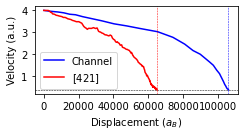

In [18]:
fig, ax = plt.subplots()

ax.plot(pos_channel['displacement'], pos_channel['velocity'], 'b', label='Channel')
ax.plot(pos_offchannel['displacement'], pos_offchannel['velocity'], 'r', label='$[4 2 1]$')

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Velocity (a.u.)')

ax.legend()

# Plot the stopping distance and time
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), [0.4]*2, 'k--', lw=0.5)
ax.plot([dist_offchannel]*2, ax.get_ylim(), 'r--', lw=0.5)
ax.plot([dist_channel]*2, ax.get_ylim(), 'b--', lw=0.5)


fig.set_size_inches(3.5, 2)
fig.tight_layout()

*Finding*: The stopping power calculator works. But the trajectory is rough, and this might be a sign of a problem with the ODE solver making mistakes in the integration due to too large of timesteps.

### Determine a Good Step Size
Study how well the stopping distance converages with step size. This off-channel should give a better representation of a 'hard to converge' integral than the channel (i.e., it is more likely to be strongly affected by timestep size), which is visible in the relative smoothness of the channel trajecotry compared to the $[4 2 1]$ trajectory.  

In [19]:
step_sizes = np.logspace(-1, 2, 12)

In [20]:
stop_dists = []
stop_trajs = []
for m in step_sizes:
    try: 
        stop_comp.max_step = m  # Set the step size
        d, s = stop_comp.compute_stopping_distance([0, 0.75, 0.75], off_channel, output=100)
        stop_dists.append(d)
        stop_trajs.append(s)
    except RuntimeError:
        stop_dists.append(np.nan)
        stop_trajs.append(None)

Step: 341175 - Time: 34117.227742848256 - Velocity: 0.3999722207157015 - Position: 76820.464889797053
Step: 181998 - Time: 34102.56793037682 - Velocity: 0.399998473411443 - Position: 76811.71465593272575
Step: 97231 - Time: 34138.54155482884 - Velocity: 0.3998321972660419 - Position: 76810.8813266928964
Step: 51864 - Time: 34120.69471134291 - Velocity: 0.39996944225257214 - Position: 76705.172308060145
Step: 27780 - Time: 34243.828715338735 - Velocity: 0.39990293405021615 - Position: 77171.45841671225
Step: 14851 - Time: 34298.77333771299 - Velocity: 0.39909623280403855 - Position: 77302.309132189081
Step: 8010 - Time: 34654.511110801584 - Velocity: 0.39885972553613747 - Position: 78040.06817553296
Step: 4126 - Time: 33429.47859257726 - Velocity: 0.39931139110570857 - Position: 72702.007428150985
Step: 2388 - Time: 36162.51805033634 - Velocity: 0.39687331990287605 - Position: 77839.57841192294
Step: 1431 - Time: 39349.08842834603 - Velocity: 0.3996906641604254 - Position: 74328.0867152

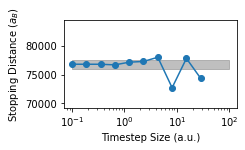

In [21]:
fig, ax = plt.subplots()

# Plot the results
ax.fill_between([step_sizes.min(), step_sizes.max()], [stop_dists[0] * 1.01]*2, 
                [stop_dists[0] * 0.99]*2, color='gray', alpha=0.5)

ax.semilogx(step_sizes, stop_dists, 'o-')

ax.set_ylim(stop_dists[0] * 0.9, stop_dists[0] * 1.1)

ax.set_xlabel('Timestep Size (a.u.)')
ax.set_ylabel('Stopping Distance ($a_B$)')

fig.set_size_inches(3.5, 2)
fig.tight_layout()

Find the largest timestep that is within 1% of the 0.1 a.u. timestep result

In [22]:
for i, _ in enumerate(step_sizes):
    if abs(stop_dists[i] - stop_dists[0]) / stop_dists[0] > 0.01:
        break
best_timestep = step_sizes[i - 1]
print('Optimal timestep: {:.2f}'.format(best_timestep))

Optimal timestep: 2.31


Based on this result, we'll pick a timestep size of 1 a.u. to be conservative

In [23]:
stop_comp.max_step = 1
assert 1 < best_timestep

## Save the Computer
Save it to disk for later use

In [24]:
with open('stop_dist_computer.pkl', 'wb') as fp:
    pkl.dump(stop_comp, fp)